Assignment completed by:
- Castelli Giorgia giorgia.castelli2@studio.unibo.it
- Fratini Alice fratini.alice2@studio.unibo.it
- Mone Madalina Ionela madalina.mone@studio.unibo.it

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


## Imports and device setting

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image
from typing import List, Tuple
import copy
import random


import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Dataset exploration

In [7]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # reads a text file containing the paths of the images and the associated labels
    # returns two lists: one with image paths and one with labels
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") # removes the newline character, and then splits into 3 parts using a comma as the separator
                paths.append(path), labels.append(int(label)) # saves only paths and labels

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

Generating the training, testing and validation datasets

In [8]:
train_dataset = GroceryStoreDataset(split="train")
test_dataset = GroceryStoreDataset(split="test")
val_dataset = GroceryStoreDataset(split="val")

Checking datasets length

In [9]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 2640
Test dataset size: 2485
Validation dataset size: 296


Visualizing some samples of the dataset

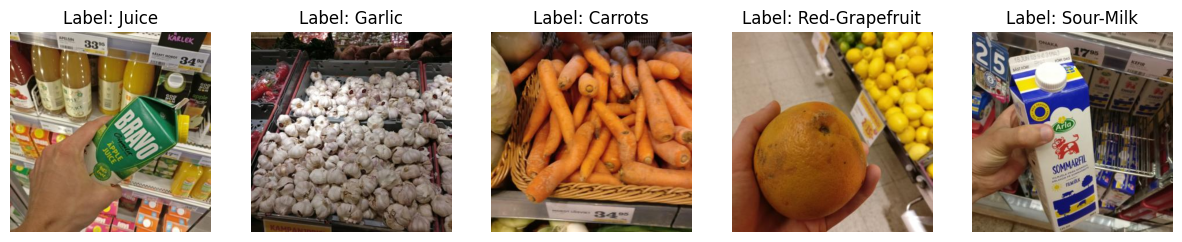

In [10]:
# Class labels mapping
CLASS_NAMES = [
    "Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon", "Nectarine", 
    "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear", "Pineapple", "Plum", "Pomegranate", 
    "Red-Grapefruit", "Satsumas", "Juice", "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", 
    "Sour-Milk", "Soyghurt", "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage", 
    "Carrots", "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom", "Onion", "Pepper", "Potato", 
    "Red-Beet", "Tomato", "Zucchini"
]

def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    transform = transforms.ToTensor()
    
    # Create a list of unique labels in the dataset
    unique_labels = list(set(label for _, label in dataset))
    random.shuffle(unique_labels)
    
    # Select num_samples unique labels
    selected_labels = unique_labels[:num_samples]
    
    for i, label in enumerate(selected_labels):
        # Find the first image with the selected label
        for img, img_label in dataset:
            if img_label == label:
                img_tensor = transform(img)  # Convert PIL image to tensor
                axes[i].imshow(img_tensor.permute(1, 2, 0))  # Permute to HWC
                axes[i].set_title(f"Label: {CLASS_NAMES[label]}")
                axes[i].axis('off')
                break
    
    plt.show()

# Show sample images from the train dataset
show_sample_images(train_dataset, num_samples=5)

Checking image sizes

In [11]:
def check_image_sizes(dataset, dataset_name):
    sizes = set()
    
    for img, _ in dataset:
        sizes.add(img.size)
    
    print(f"Unique image sizes for {dataset_name}:")
    for size in sizes:
        print(f"- {size}")
    print("\n")

check_image_sizes(train_dataset, "train_dataset")
check_image_sizes(test_dataset, "test_dataset")
check_image_sizes(val_dataset, "val_dataset")

Unique image sizes for train_dataset:
- (348, 464)
- (464, 348)
- (348, 348)


Unique image sizes for test_dataset:
- (348, 464)
- (464, 348)
- (348, 348)


Unique image sizes for val_dataset:
- (348, 348)




Checking class distribution among datasets and visualization

In [12]:
print(f"Number of classes in the train dataset: {train_dataset.get_num_classes()}")
print(f"Number of classes in the test dataset: {test_dataset.get_num_classes()}")
print(f"Number of classes in the validation dataset: {val_dataset.get_num_classes()}")

if train_dataset.get_num_classes() == test_dataset.get_num_classes() == val_dataset.get_num_classes():
    print("Number of classes is consistent across datasets")
else:
    print("Number of classes is not consistent across datasets")

Number of classes in the train dataset: 43
Number of classes in the test dataset: 43
Number of classes in the validation dataset: 43
Number of classes is consistent across datasets


In [13]:
def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    distribution = Counter(labels)
    return distribution

train_distribution = get_class_distribution(train_dataset)
test_distribution = get_class_distribution(test_dataset)
val_distribution = get_class_distribution(val_dataset)

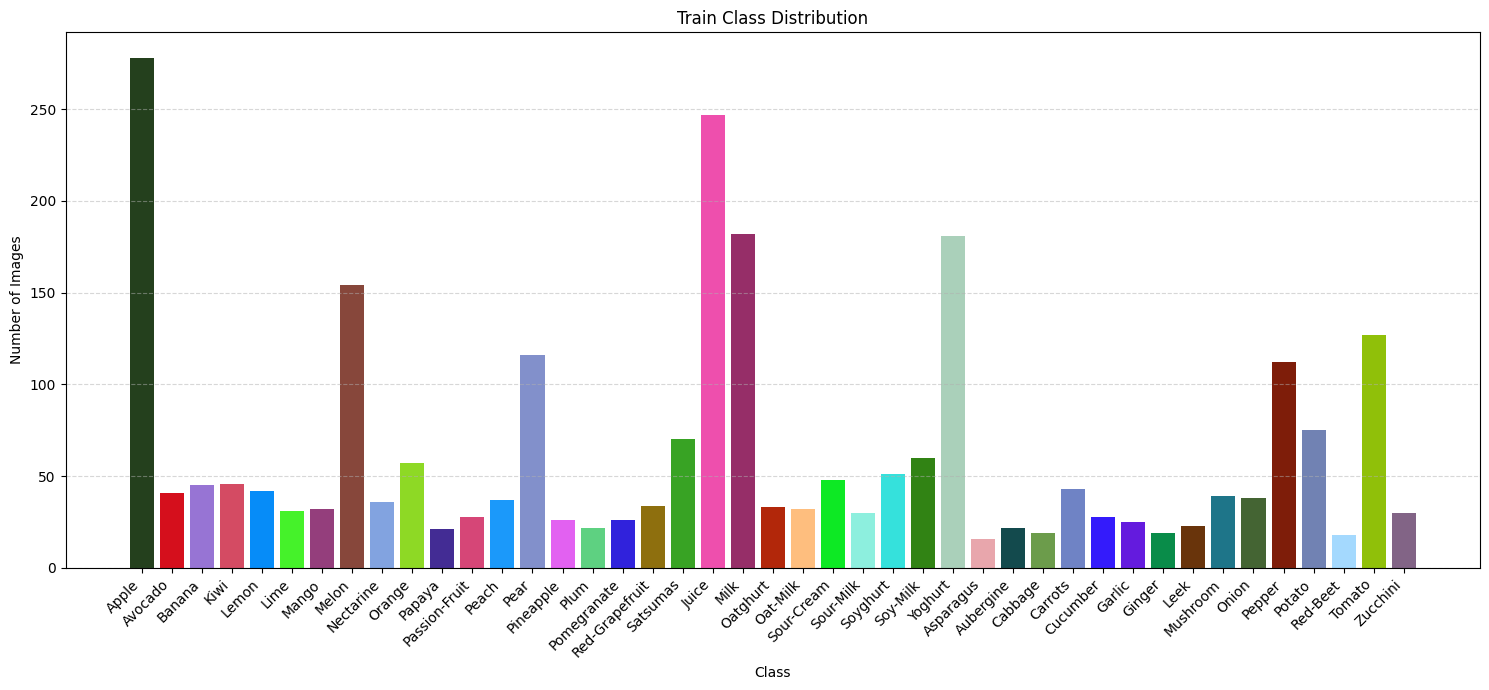

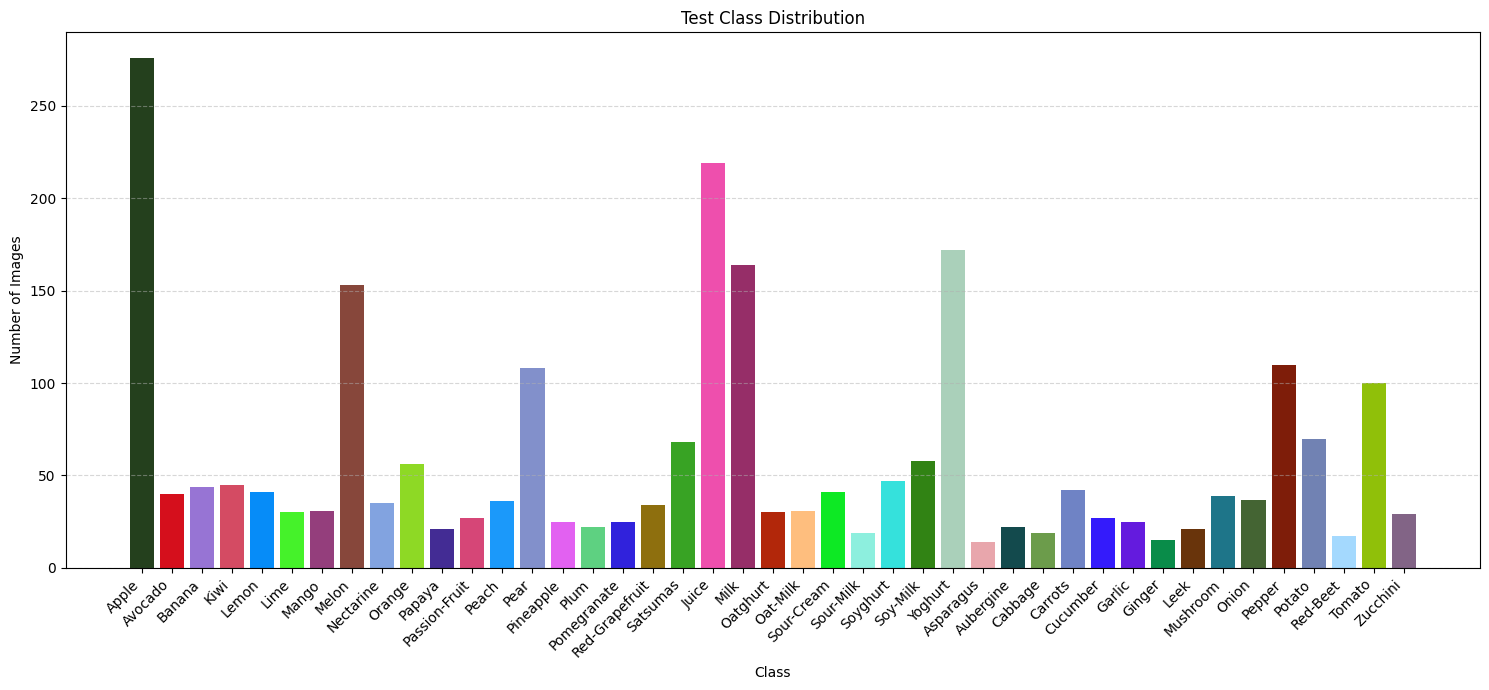

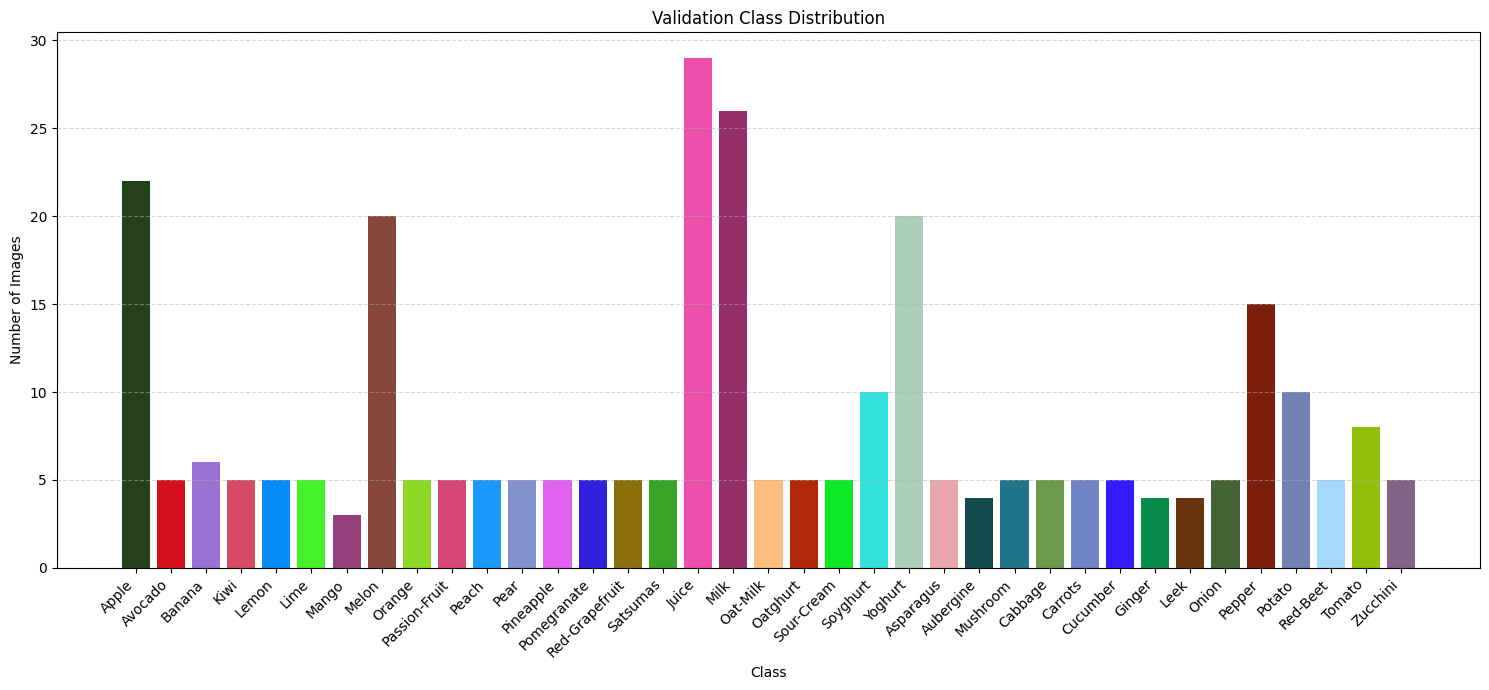

In [14]:
# Pre-generate consistent colors for each class
def generate_class_colors():
    np.random.seed(42)  # Ensure reproducibility
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in CLASS_NAMES]
    return colors

# Create a dictionary of class indices and their corresponding colors
CLASS_COLORS = generate_class_colors()

def plot_class_distribution(distribution, title):
    class_indices = list(distribution.keys())
    class_counts = list(distribution.values())
    class_labels = [CLASS_NAMES[idx] for idx in class_indices]
    colors = [CLASS_COLORS[idx] for idx in class_indices]
    
    plt.figure(figsize=(15, 7))
    plt.bar(class_labels, class_counts, color=colors)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()  # Adjust layout to make room for the plot
    plt.show()

plot_class_distribution(train_distribution, "Train Class Distribution")
plot_class_distribution(test_distribution, "Test Class Distribution")
plot_class_distribution(val_distribution, "Validation Class Distribution")


## Image resizing  

Since images don't have the same size, we will resize them all to a fixed shape. We choose (224, 224) because it is the standard input size for ResNet18, which was pre-trained on ImageNet using this resolution. This size ensures compatibility with the pre-trained model, balances computational efficiency, and retains enough detail for effective feature extraction.

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [16]:
train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

Check new sizes after resizing

In [17]:
def check_image_sizes(dataset, dataset_name):
    sizes = set()
    
    for img, _ in dataset:
        sizes.add(tuple(img.shape))
    
    print(f"Unique image sizes for {dataset_name}:")
    for size in sizes:
        print(f"- {size}")
    print("\n")

check_image_sizes(train_dataset, "train_dataset")
check_image_sizes(test_dataset, "test_dataset")
check_image_sizes(val_dataset, "val_dataset")

Unique image sizes for train_dataset:
- (3, 224, 224)


Unique image sizes for test_dataset:
- (3, 224, 224)


Unique image sizes for val_dataset:
- (3, 224, 224)




## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

# Utility functions 
Defining here the functions we will use for training the neural network, evaluate it and plotting the results. 

In [53]:
# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Crea un generatore randomico con il seed impostato
g = torch.Generator()
g.manual_seed(42)

In [30]:
def train_model(model, train_loader, val_loader, num_epochs, patience):
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
    # Scheduler
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    # Initialize best model weights and metrics
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0
    early_stop_counter = 0

    # Lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # Training phase
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        running_train_corrects = 0

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            running_train_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = running_train_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_val_loss = 0.0
        running_val_corrects = 0

        # Disable gradient computation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_val_loss += loss.item() * inputs.size(0)
                running_val_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = running_val_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Update best validation accuracy
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        # Step the scheduler
        scheduler.step()
    print("===========================================")
    print(f'Best accuracy on validation set: {(best_acc*100):.2f}%')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [46]:
def evaluate_model(model, test_loader):
	# Loss function
	criterion = nn.CrossEntropyLoss()

	# Set model to evaluation mode
	model.eval()
	test_running_loss = 0.0
	correct = 0
	total = 0

	# Disable gradient computation
	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(device), labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)
			test_running_loss += loss.item() * images.size(0)

			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	
	# Calculate average loss and accuracy
	test_loss = test_running_loss / len(test_loader.dataset)
	test_accuracy = 100 * correct / total
	
	# Print metrics
	print(f"Cnn's accuracy on test set: {test_accuracy:.2f}%")

In [43]:
def plot_training_history(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float]):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot loss
    plt.plot(epochs, train_losses, label='Train Loss', color='#AEC6CF', linestyle='-', marker='*')
    plt.plot(epochs, val_losses, label='Val Loss', color='#77DD77', linestyle='-', marker='*')
    
    # Plot accuracy
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='#FFB347', linestyle='-', marker='D')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', color='#FF6961', linestyle='-', marker='D')  
    
    plt.title('Training and Validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    # Remove the border lines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    plt.show()

## First attempt of convolutional neural network

The FirstCNN architecture leverages convolutional and pooling layers for feature extraction and fully connected layers for classification, with regularization techniques to enhance generalization. 

It starts with three convolutional layers followed by fully connected layers. The first convolutional layer applies 16 filters to the input image, extracting basic features like edges. 
Batch normalization and max pooling are applied to stabilize training and reduce spatial dimensions. 

The second convolutional layer, with 32 filters, extracts more complex features, while the third layer uses 64 filters to capture fine details. 

The output is then flattened and passed through fully connected layers. 

The first fully connected layer reduces the output to 128 units, followed by another layer with 84 units. 
A dropout layer is applied after the first fully connected layer to prevent overfitting. 

The final layer produces the class scores, with 43 units corresponding to the number of classes.

In [22]:
class FirstCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(FirstCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(16)  # BatchNorm after conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)  # BatchNorm after conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # BatchNorm after conv3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Determining the input size to the fully connected layer
        self._to_linear = None
        self._compute_linear_input(torch.randn(1, 3, 224, 224))  # Simulate a forward pass
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def _compute_linear_input(self, x):
        """Method to determine the flattened input size after convolutions."""
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        self._to_linear = x.view(-1).shape[0]

    def forward(self, x):
        # Passing through convolutional layers
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten, fully connected layers, and dropout
        x = x.view(-1, self._to_linear)
        
        # Passing through the fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
first_cnn= FirstCNN()
first_cnn.to(device)
summary(first_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
       BatchNorm2d-2         [-1, 16, 220, 220]              32
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
       BatchNorm2d-5         [-1, 32, 106, 106]              64
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Conv2d-7           [-1, 64, 53, 53]          18,496
       BatchNorm2d-8           [-1, 64, 53, 53]             128
         MaxPool2d-9           [-1, 64, 26, 26]               0
           Linear-10                  [-1, 128]       5,537,920
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 84]          10,836
           Linear-13                   [-1, 43]           3,655
Total params: 5,585,179
Trainable param

### Training hyperparameters
We begin by setting the following hyperparameters: 
- Batch_size = 32 ensures a good balance between computational efficiency, memory usage, and stable gradient updates.
Batch sizes of 32 or 64 are common choices in CNN training, as they have been shown empirically to perform well across various architectures and datasets, so we begin with 32.
- Num_epochs = 30 provides enough iterations for learning while preventing excessive overfitting.
While the ideal number of epochs depends on the dataset and model complexity, we think starting with 30 is a reasonable choice for our problem.
- Patience = 7 ensures that early stopping prevents unnecessary training while allowing the model to improve over time.
Given that 30 epochs are set as the maximum, allowing the model 7 epochs (almost one-quarter of the total) to attempt improvement before stopping ensures that early stopping doesn’t cut off training before meaningful convergence is achieved

In [23]:
BATCH_SIZE = 32
NUM_EPOCHS =30
PATIENCE = 7

Data loader

In [24]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training the first implementation of the cnn
With our first implementation we obtain an accuracy on validation set around 36% and an accuracy on test set of 47%.
While these results are not a bad starting point, they also indicate that there is significant room for improvement.

There are several areas where we can enhance the model's performance, such as data preprocessing, adding more advanced regularization techniques, experimenting with different network architectures, or increasing the amount of training data. With further adjustments and optimizations, we can aim to achieve much better results.


In [34]:
first_cnn_model, first_train_losses, first_train_accuracies, first_val_losses, first_val_accuracies, = train_model(first_cnn, train_loader, val_loader, NUM_EPOCHS, PATIENCE)

Epoch [1/30], Train Loss: 1.3727 Acc: 0.5746 | Val Loss: 2.2625 Acc: 0.3378
Epoch [2/30], Train Loss: 1.3146 Acc: 0.5973 | Val Loss: 2.2920 Acc: 0.3243
Epoch [3/30], Train Loss: 1.2300 Acc: 0.6265 | Val Loss: 2.2528 Acc: 0.3243
Epoch [4/30], Train Loss: 1.1833 Acc: 0.6383 | Val Loss: 2.1805 Acc: 0.3581
Epoch [5/30], Train Loss: 1.1541 Acc: 0.6462 | Val Loss: 2.1587 Acc: 0.3480
Epoch [6/30], Train Loss: 1.0906 Acc: 0.6629 | Val Loss: 2.1444 Acc: 0.3446
Epoch [7/30], Train Loss: 1.0275 Acc: 0.6769 | Val Loss: 2.1146 Acc: 0.3649
Epoch [8/30], Train Loss: 0.9734 Acc: 0.7034 | Val Loss: 2.1298 Acc: 0.3480
Epoch [9/30], Train Loss: 0.9750 Acc: 0.6981 | Val Loss: 2.1182 Acc: 0.3581
Epoch [10/30], Train Loss: 0.9457 Acc: 0.7072 | Val Loss: 2.1635 Acc: 0.3412
Epoch [11/30], Train Loss: 0.9370 Acc: 0.7072 | Val Loss: 2.1152 Acc: 0.3446
Epoch [12/30], Train Loss: 0.9103 Acc: 0.7265 | Val Loss: 2.1239 Acc: 0.3480
Epoch [13/30], Train Loss: 0.9094 Acc: 0.7205 | Val Loss: 2.1361 Acc: 0.3581
Epoch [1

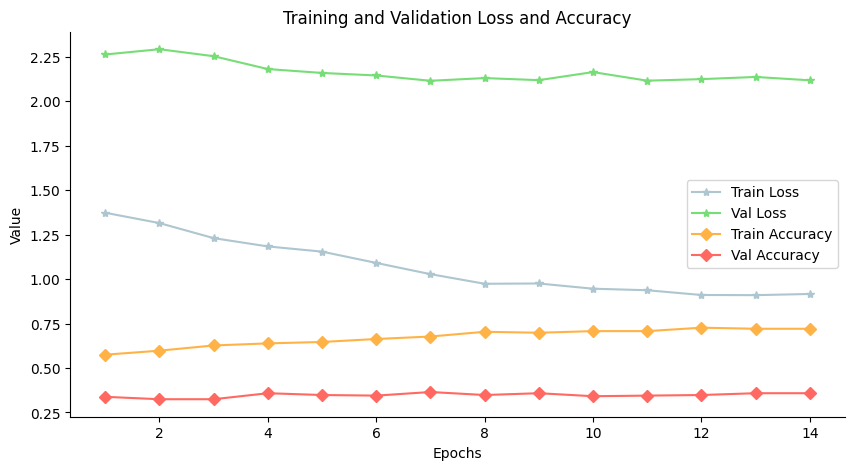

In [44]:
plot_training_history(first_train_losses, first_val_losses, first_train_accuracies, first_val_accuracies)

In [47]:
evaluate_model(first_cnn_model, test_loader)

Cnn's accuracy on test set: 47.89%


## Normalization

Why Normalize?
Normalization is a crucial preprocessing step in CNN training for the following reasons:

- Accelerates Convergence:
By scaling pixel values to a consistent range (usually centered around 0 with a standard deviation of 1), normalization helps in faster convergence during training. This is because normalized data ensures that gradient updates across layers remain stable.

- Reduces Covariate Shift:
Without normalization, varying scales of input pixel values across channels (R, G, B) can lead to inconsistent gradient updates. Normalization mitigates this problem by ensuring all input channels have a similar distribution.

- Improves Generalization:
Models trained on normalized data are less prone to overfitting, as normalization reduces sensitivity to variations in pixel intensity across the dataset.

The function `calculate_mean_std` is designed to compute the mean and standard deviation for each RGB channel, which will be used for normalization.

The function iterates over the dataset in batches using the DataLoader. For each batch, it reshapes the images from the format [B, C, H, W] to [B, C, H* W], where B is the batch size, C is the number of channels (3 for RGB), and H*W represents the flattened spatial dimensions of the images. Then, the mean and standard deviation are calculated along the spatial dimension (i.e., for each pixel across the height and width) for each channel (RGB). These values are summed for each batch, and the total sum is accumulated. After processing all batches, the accumulated sums of the mean and standard deviation are divided by the total number of samples to obtain the final mean and standard deviation for the entire dataset.

In [62]:
def calculate_mean_std(dataset, batch_size=64):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    mean = torch.zeros(3) 
    std = torch.zeros(3)
    nb_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)  # number of samples in batch
        data = data.view(batch_samples, 3, -1)  # [B, C, H*W]
        
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)    
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(train_dataset)


Applying the normalization

In [54]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Normalize with mean and std calculated above
])

train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Training again the same cnn to see if the dataset normalization bring improvements on the accuracy

In [52]:
first_cnn_model, first_train_losses, first_train_accuracies, first_val_losses, first_val_accuracies, = train_model(first_cnn, train_loader, val_loader, NUM_EPOCHS, PATIENCE)

Epoch [1/30], Train Loss: 0.7937 Acc: 0.7455 | Val Loss: 2.2915 Acc: 0.3209
Epoch [2/30], Train Loss: 0.7571 Acc: 0.7553 | Val Loss: 2.2268 Acc: 0.3480
Epoch [3/30], Train Loss: 0.6968 Acc: 0.7867 | Val Loss: 2.3711 Acc: 0.3446
Epoch [4/30], Train Loss: 0.7120 Acc: 0.7701 | Val Loss: 2.3408 Acc: 0.3277
Epoch [5/30], Train Loss: 0.6941 Acc: 0.7879 | Val Loss: 2.3421 Acc: 0.3514
Epoch [6/30], Train Loss: 0.6753 Acc: 0.7860 | Val Loss: 2.4030 Acc: 0.3412
Epoch [7/30], Train Loss: 0.6308 Acc: 0.7924 | Val Loss: 2.2924 Acc: 0.3851
Epoch [8/30], Train Loss: 0.5762 Acc: 0.8201 | Val Loss: 2.3041 Acc: 0.3547
Epoch [9/30], Train Loss: 0.5693 Acc: 0.8242 | Val Loss: 2.3299 Acc: 0.3412
Early stopping triggered
Best accuracy on validation set: 38.51%


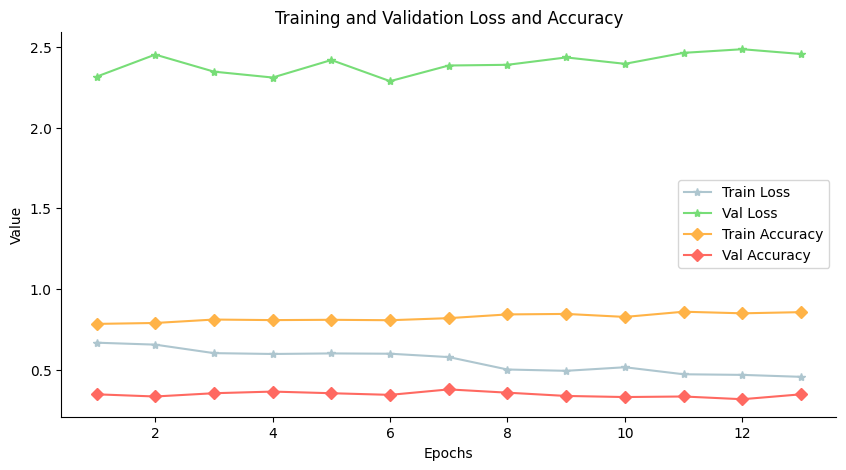

In [57]:
plot_training_history(first_train_losses, first_val_losses, first_train_accuracies, first_val_accuracies)

In [58]:
evaluate_model(first_cnn_model, test_loader)

Cnn's accuracy on test set: 48.57%


As we can see, we obtained an accuracy of 38% on the validation set and an accuracy of 48% on the test set. The normalization process did not lead to significant changes in the model's training performance. Despite the slight improvement, we can try to further enhance the results, and this time we will modify the architecture of our convolutional neural network.

## Second attempt of convolutional neural network

The SecondCNN architecture improves upon the first by introducing deeper convolutions, residual connections, and adaptive pooling. It starts with two convolutional layers in the first block, where the number of filters increases from 32 to 48, followed by batch normalization and max pooling. In the second block, the number of filters grows from 48 to 96 using 5x5 kernels, with batch normalization and max pooling applied similarly.

A key difference is the inclusion of a residual connection in the third block. Two additional convolutional layers with 128 filters each are used, with a shortcut that adds the block’s input to the output, helping alleviate the vanishing gradient problem. The output is passed through an **Adaptive Average Pooling** layer, reducing the spatial dimensions to 1x1, ensuring a fixed-size output.

After flattening, the model passes through two fully connected layers, with a dropout layer between them to prevent overfitting. The final layer outputs class predictions.

Compared to the first CNN, this model’s deeper architecture and residual connection improve its ability to capture complex features and stabilize training, making it more capable of handling difficult data and achieving better performance.

In [ ]:
class SecondCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(SecondCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(48)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer
        self.conv3 = nn.Conv2d(48, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(96)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Third convolutional layer with residual connection
        self.conv5 = nn.Conv2d(96, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # reduces the spatial dimensions to a fixed size
        
        # Residual connection
        self.shortcut = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convoluzional block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        
        # Second convoluzional block
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        
        # Third convolutional block with residual connection
        shortcut = self.shortcut(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x + shortcut  # Residual connection
        x = self.pool3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


second_cnn = SecondCNN()
second_cnn.to(device)
summary(second_cnn, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]          13,872
       BatchNorm2d-5         [-1, 48, 112, 112]              96
         MaxPool2d-6           [-1, 48, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          76,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10           [-1, 96, 28, 28]         153,696
      BatchNorm2d-11           [-1, 96, 28, 28]             192
        MaxPool2d-12           [-1, 96, 14, 14]               0
           Conv2d-13          [-1, 128, 14, 14]          12,416
      BatchNorm2d-14          [-1, 128,

In this attempt we also sperimented with hyperparameters, increasing the number of epochs and the epochs of patience.

In [63]:
second_cnn_model, second_train_losses, second_train_accuracies, second_val_losses, second_val_accuracies, = train_model(second_cnn, train_loader, val_loader, 45, 10)

Epoch [1/45], Train Loss: 1.3404 Acc: 0.6254 | Val Loss: 1.7425 Acc: 0.5034
Epoch [2/45], Train Loss: 1.2600 Acc: 0.6383 | Val Loss: 1.7181 Acc: 0.5000
Epoch [3/45], Train Loss: 1.2351 Acc: 0.6326 | Val Loss: 1.6872 Acc: 0.5068
Epoch [4/45], Train Loss: 1.1673 Acc: 0.6644 | Val Loss: 1.7929 Acc: 0.4459
Epoch [5/45], Train Loss: 1.1405 Acc: 0.6705 | Val Loss: 1.7523 Acc: 0.4966
Epoch [6/45], Train Loss: 1.0923 Acc: 0.6814 | Val Loss: 1.7304 Acc: 0.5169
Epoch [7/45], Train Loss: 1.0638 Acc: 0.6890 | Val Loss: 1.7514 Acc: 0.4831
Epoch [8/45], Train Loss: 0.9989 Acc: 0.7008 | Val Loss: 1.4249 Acc: 0.5676
Epoch [9/45], Train Loss: 0.9501 Acc: 0.7333 | Val Loss: 1.4851 Acc: 0.5845
Epoch [10/45], Train Loss: 0.9453 Acc: 0.7375 | Val Loss: 1.4411 Acc: 0.5709
Epoch [11/45], Train Loss: 0.9444 Acc: 0.7330 | Val Loss: 1.4144 Acc: 0.5642
Epoch [12/45], Train Loss: 0.9359 Acc: 0.7523 | Val Loss: 1.4190 Acc: 0.5709
Epoch [13/45], Train Loss: 0.9134 Acc: 0.7345 | Val Loss: 1.4880 Acc: 0.5507
Epoch [1

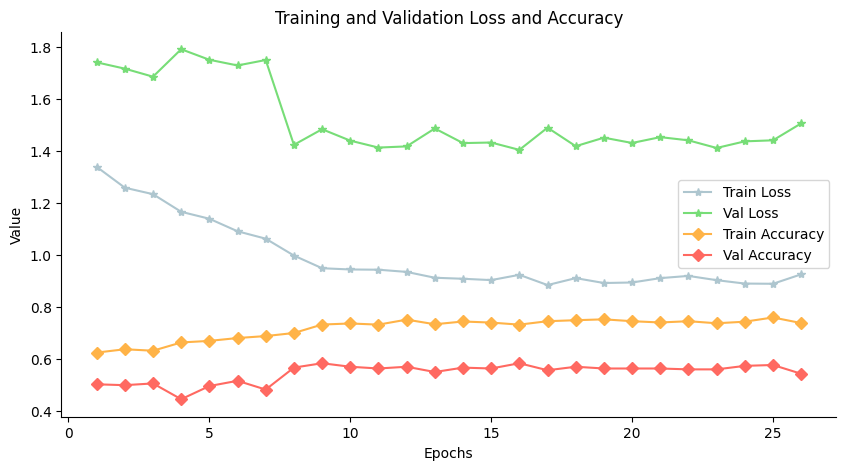

In [64]:
plot_training_history(second_train_losses, second_val_losses, second_train_accuracies, second_val_accuracies)

In [65]:
evaluate_model(second_cnn_model, test_loader)

Cnn's accuracy on test set: 61.89%


As we can see from these new results, 58% of accuracy on validation and 61% of accuracy on test set, there has been a significant change, indicating that the deeper CNN architecture and the adaptive average pooling layer have contributed to improved performance.

Until now we sperimented only with number of epochs, in total and for patience. Let's see how the same cnn architecture performs increasing the batch size.

In [66]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [67]:
second_cnn_model, second_train_losses, second_train_accuracies, second_val_losses, second_val_accuracies, = train_model(second_cnn, train_loader, val_loader, 45, 10)

Epoch [1/45], Train Loss: 0.8891 Acc: 0.7443 | Val Loss: 1.4693 Acc: 0.5912
Epoch [2/45], Train Loss: 0.8589 Acc: 0.7606 | Val Loss: 1.5138 Acc: 0.5372
Epoch [3/45], Train Loss: 0.8529 Acc: 0.7481 | Val Loss: 1.6161 Acc: 0.5574
Epoch [4/45], Train Loss: 0.8233 Acc: 0.7621 | Val Loss: 1.5004 Acc: 0.5270
Epoch [5/45], Train Loss: 0.7816 Acc: 0.7799 | Val Loss: 1.7263 Acc: 0.5135
Epoch [6/45], Train Loss: 0.7527 Acc: 0.7894 | Val Loss: 1.5030 Acc: 0.5236
Epoch [7/45], Train Loss: 0.7496 Acc: 0.7856 | Val Loss: 1.7755 Acc: 0.5101
Epoch [8/45], Train Loss: 0.6750 Acc: 0.8023 | Val Loss: 1.3928 Acc: 0.5777
Epoch [9/45], Train Loss: 0.6595 Acc: 0.8303 | Val Loss: 1.3731 Acc: 0.5811
Epoch [10/45], Train Loss: 0.6658 Acc: 0.8216 | Val Loss: 1.4128 Acc: 0.5811
Epoch [11/45], Train Loss: 0.6671 Acc: 0.8277 | Val Loss: 1.3953 Acc: 0.5743
Epoch [12/45], Train Loss: 0.6711 Acc: 0.8189 | Val Loss: 1.4173 Acc: 0.5878
Epoch [13/45], Train Loss: 0.6528 Acc: 0.8159 | Val Loss: 1.3818 Acc: 0.5743
Epoch [1

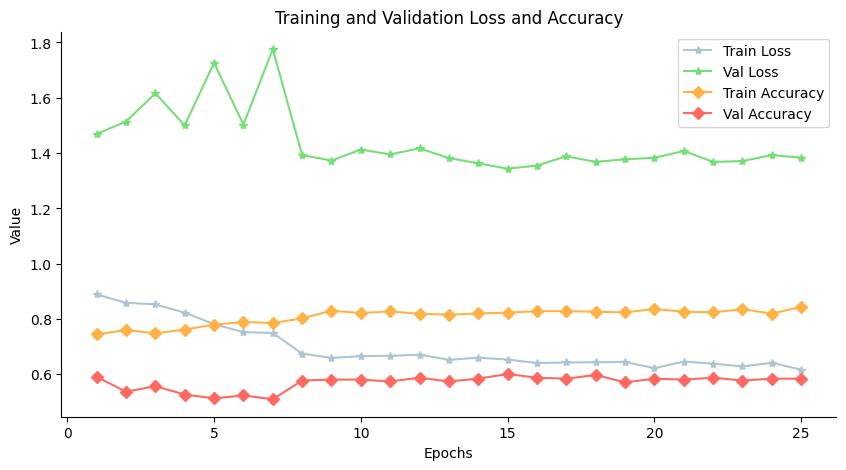

In [69]:
plot_training_history(second_train_losses, second_val_losses, second_train_accuracies, second_val_accuracies)

In [68]:
evaluate_model(second_cnn_model, test_loader)

Cnn's accuracy on test set: 65.03%


The results show a noticeable improvement after increasing the batch size from 32 to 64. 

With the original batch size, the validation accuracy peaked at 58.45%, and the model showed a relatively slower improvement over the epochs, with some fluctuations in performance. 

However, after increasing the batch size, the training loss decreased more consistently, and the validation accuracy reached 60.14%, reflecting a more stable and efficient learning process.

This change in batch size allowed the model to process more data in each iteration, which likely helped stabilize the optimization and led to better generalization, as evidenced by the increased validation accuracy. 

Despite the guidelines of the assignments saying that we should consider satisfied with our implementation once we obtain an accuracy on validation set at around 60%, we would like to make one last improvement: **data augmentation**. 

Deeper CNNs often require more data to perform well. This is because deeper networks have more parameters and are capable of learning more complex features, but they also tend to overfit if they don't have enough training data. When there is limited data, a deep CNN might not generalize well to unseen examples and instead memorize patterns specific to the training set, leading to overfitting.

Data augmentation techniques can significantly help in such cases by artificially increasing the size of the training set. These techniques involve creating modified versions of the existing data through transformations. By exposing the model to more varied examples, data augmentation can reduce overfitting and improve the performance of the model, particularly on the validation and test sets. 

In [70]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_da = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean, std),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
])

The data augmentation test consist in applying two simple transformations: random horizontal flips with a 50% chance (RandomHorizontalFlip(p=0.5)) and random rotations up to 30 degrees (RandomRotation(30)). These techniques introduce variability in the training data, helping the model generalize better and become more robust to different orientations and perspectives of the objects in the images.

In [71]:
train_dataset = GroceryStoreDataset(split="train", transform=transform_da) #apply data augmentation only on training dataset
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [73]:
second_cnn_model, second_train_losses, second_train_accuracies, second_val_losses, second_val_accuracies, = train_model(second_cnn, train_loader, val_loader, 45, 10)

Epoch [1/45], Train Loss: 0.7425 Acc: 0.7905 | Val Loss: 1.6424 Acc: 0.5169
Epoch [2/45], Train Loss: 0.7252 Acc: 0.7864 | Val Loss: 1.4480 Acc: 0.5777
Epoch [3/45], Train Loss: 0.6847 Acc: 0.8000 | Val Loss: 1.6878 Acc: 0.5270
Epoch [4/45], Train Loss: 0.6759 Acc: 0.8011 | Val Loss: 1.4815 Acc: 0.5574
Epoch [5/45], Train Loss: 0.6361 Acc: 0.8136 | Val Loss: 1.5477 Acc: 0.5676
Epoch [6/45], Train Loss: 0.6607 Acc: 0.8042 | Val Loss: 1.5361 Acc: 0.5845
Epoch [7/45], Train Loss: 0.6113 Acc: 0.8261 | Val Loss: 1.5393 Acc: 0.5574
Epoch [8/45], Train Loss: 0.5728 Acc: 0.8360 | Val Loss: 1.3633 Acc: 0.6047
Epoch [9/45], Train Loss: 0.5687 Acc: 0.8348 | Val Loss: 1.3593 Acc: 0.6216
Epoch [10/45], Train Loss: 0.5471 Acc: 0.8466 | Val Loss: 1.3478 Acc: 0.6115
Epoch [11/45], Train Loss: 0.5532 Acc: 0.8417 | Val Loss: 1.3177 Acc: 0.6182
Epoch [12/45], Train Loss: 0.5230 Acc: 0.8576 | Val Loss: 1.3867 Acc: 0.6149
Epoch [13/45], Train Loss: 0.5473 Acc: 0.8511 | Val Loss: 1.3534 Acc: 0.6250
Epoch [1

In [96]:
evaluate_model(second_cnn_model, test_loader)

Test Loss: 1.0951, Test Accuracy: 67.12%


Data augmentation led to a modest improvement in the validation accuracy, which reached 62% compared to 60% in theprevious trainingwithout augmentation. While this represents a slight gain, it is not a dramatic change. The model's performance remained relatively stable across the epochs, with small fluctuations in accuracy. While data augmentation helped to slightly improve generalization, the impact on the overall performance was not as substantial as expected, suggesting there might be other factors that could be further explored for improvement.

Now that the accuracy on the validation set hovers around 60% for most epochs, we can consider this satisfactory and move on to the second part of the assignment. 

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.